<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/Fall2025/Week08/intro_nn_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device to be used: cpu

Epoch 1/5
Mini batch 1, Loss: 73.8061
Mini batch 101, Loss: 5.5600
Mini batch 201, Loss: 31.5492
Mini batch 301, Loss: 13.1459
Mini batch 401, Loss: 5.6699
Mini batch 501, Loss: 7.7575
Mini batch 601, Loss: 24.6831
Mini batch 701, Loss: 17.3286
Mini batch 801, Loss: 7.5722
Mini batch 901, Loss: 1.3379
Mini batch 1001, Loss: 8.1941
Mini batch 1101, Loss: 10.8528
Mini batch 1201, Loss: 6.0498
Mini batch 1301, Loss: 0.4088
Mini batch 1401, Loss: 1.8112
Mini batch 1501, Loss: 15.9545
Mini batch 1601, Loss: 0.3120
Mini batch 1701, Loss: 8.9706
Mini batch 1801, Loss: 14.8453
Epoch average loss: 0.2983
Validation Accuracy: 93.82%

Epoch 2/5
Mini batch 1, Loss: 13.0874
Mini batch 101, Loss: 11.4326
Mini batch 201, Loss: 13.6563
Mini batch 301, Loss: 5.0731
Mini batch 401, Loss: 11.5835
Mini batch 501, Loss: 5.6154
Mini batch 601, Loss: 0.9745
Mini batch 701, Loss: 2.4167
Mini batch 801, Loss: 1.0447
Mini batch 901, Loss: 2.4704
Mini batch 1001, Loss: 4.9519
Mini batch 1

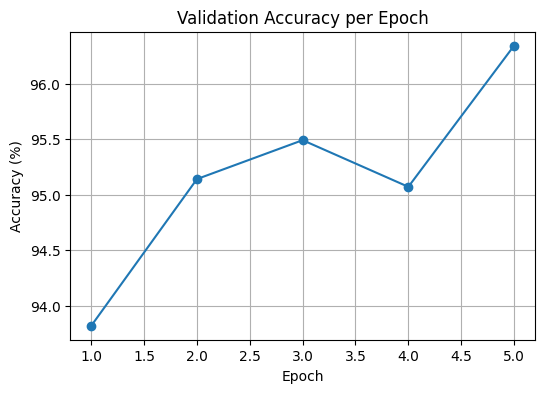

In [1]:
"""
This script demonstrates a simple fully-connected neural network (MLP) for
classifying MNIST handwritten digits using PyTorch.

It is designed for teaching purposes:
- Provides a step-by-step introduction to the basics of neural networks
- Uses standard PyTorch components (datasets, transforms, dataloaders, models,
  training loop, evaluation) in a clear pipeline
- Helps prepare students for general introductions to neural networks in PyTorch
- Closely resembles the first example notebook in NVIDIA’s
  "Fundamentals of Deep Learning" DLI training, so it can serve as
  a good warm-up or companion resource.

Author: Dr. Olcay Kursun
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# 1. Setup: random seeds and device
# ------------------------------
torch.manual_seed(42)
# Note on initialization:
# - Layers like nn.Linear randomly initialize their weights immediately when you create them.
# - That’s why setting torch.manual_seed() before creating layers ensures
#   the same starting weights every run.

# np.random.seed(42)  # We don’t actually use NumPy here, so no need to seed it.
#   But: if you were using scikit-learn such as train_test_split or NumPy-based preprocessing,
#   setting np.random.seed() would ensure reproducibility there too.)

# Pick GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device to be used:", device)

# ------------------------------
# 2. Load MNIST dataset
# ------------------------------
# Download training and test data (digits 0–9, 28x28 grayscale images)
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False)

# Define how to transform raw images into tensors
# Note: RandomRotation is a simple augmentation (small tilt)
#       applied to both train and test here for simplicity.
simple_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

# Apply the transform
train_dataset.transform = simple_transform
test_dataset.transform = simple_transform

# Wrap datasets into DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ------------------------------
# 3. Define the model
# ------------------------------
# A simple fully-connected neural network (MLP) for classification
layers = [
    nn.Flatten(),               # flatten 28x28 images → 784 vector
    nn.Linear(784, 512),        # fully connected layer
    nn.ReLU(),                  # non-linear activation
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)          # 10 output classes (digits 0–9)
]

model = nn.Sequential(*layers)
model.to(device)

# ------------------------------
# 4. Loss function and optimizer
# ------------------------------
# CrossEntropyLoss = combines Softmax + Negative Log Likelihood
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ------------------------------
# 5. Training function (1 epoch)
# ------------------------------
def train_model():
    model.train()  # put model into training mode
    total_loss = 0
    batch = 0

    for images, labels in train_loader:
        # Move data to GPU/CPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predictions
        outputs = model(images)

        # Compute how far predictions are from truth
        loss = criterion(outputs, labels)

        # Reset old gradients, compute new ones, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss occasionally (every 100 mini-batches)
        if batch % 100 == 0:
            print(f"Mini batch {batch+1}, Loss: {loss.item():.4f}")
        batch += 1

        # Track total loss for reporting
        total_loss += loss.item()

    # Average loss across all samples in the epoch
    print(f"Epoch average loss: {total_loss/len(train_dataset):.4f}")

# ------------------------------
# 6. Evaluation function
# ------------------------------
def evaluate_model(model):
    model.eval()  # evaluation mode (turn off dropout, etc.)
    correct = 0
    total = 0

    # Turn off gradient tracking for speed and memory efficiency
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            # torch.max returns (max_value, index). We only need index (predicted class)
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Return percentage accuracy
    return 100 * correct / total

# ------------------------------
# 7. Run training and evaluation
# ------------------------------
num_epochs = 5   # number of epochs for training
accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_model()                        # train for one epoch
    accuracy = evaluate_model(model)     # evaluate after this epoch
    accuracies.append(accuracy)          # store accuracy
    print(f"Validation Accuracy: {accuracy:.2f}%")

# ------------------------------
# Plot accuracies
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), accuracies, marker='o')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()
